# CASTOR UVMOS Spectrograph ETC - DQ and DZ White Dwarf Stars

Using the intial CASTOR UVMOS Spectrograph example, I added two functions. One designed to calculate the signal-to-noise ratio in a given region and a second to calulate the equivalent width of a given line along with its error. 

In [53]:
import astropy.units as u
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from astropy import constants as const

from castor_etc.background import Background
from castor_etc.photometry import Photometry
from castor_etc.sources import ExtendedSource, GalaxySource, PointSource
from castor_etc.telescope import Telescope

from castor_etc.uvmos_spectroscopy import UVMOS_Spectroscopy

In [54]:
def read_spectra(spectral_type, temp, abundance):
    
    """ 
    Definition
    ----------
    Reads in the parameters needed to pick a synthetic spectra.
    
    Parameters
    ----------
    spectral_type: str
        The name corresponding to the stellar type (either DZ or DQ) you'd like to view.   
    temp: int
        The temperature of the desired stellar spectra.
    abundance: float
        The abudance of the desired stellar spectra.
        
    Returns
    -------
    The wavelength and flux tables corresponding to the specified stellar type, temperature and abundance.
    
    Notes
    -----
    - This function accesses the read_DQ and read_DZ functions to open the requested synthetic spectra. 
    - This function was simply designed to allow easy access to the synthetic spectra and as a result is particular to these examples. 
    - Adjustments will need to be made if files are in different locations.
    
    """
    
    if spectral_type == "DZ":
        
        try:
            file_name = f'{spectral_type} Stars/8000{int(temp/100)}hepu_g14.11_{spectral_type}_{abundance}'
            file = open(file_name, 'r')
        except:
            file_name = f'{spectral_type} Stars/800{int(temp/100)}hepu_g14.11_{spectral_type}_{abundance}'
            file = open(file_name, 'r')
        
        return read_DZ(file)
            
    elif spectral_type == "DQ":
        if abundance < 8.5:
            try:
                file_name = f'{spectral_type} Stars/8000{int(temp/100)}hepu_g14.12_{spectral_type}_{abundance}'
                file = open(file_name, 'r')
            except:
                file_name = f'{spectral_type} Stars/800{int(temp/100)}hepu_g14.12_{spectral_type}_{abundance}'
                file = open(file_name, 'r')
        else:
            try:
                file_name = f'{spectral_type} Stars/8000{int(temp/100)}hepu_g15.12_{spectral_type}_{abundance}'
                file = open(file_name, 'r')
            except:
                file_name = f'{spectral_type} Stars/800{int(temp/100)}hepu_g15.12_{spectral_type}_{abundance}'
                file = open(file_name, 'r')
                
        return read_DQ(file)
    
def read_DZ(file):
    
    """ 
    Definition
    ----------
    Reads in the synthetic spectra for DZ White Dwarf Stars.
    
    Parameters
    ----------
    file: str
        The file for the corresponding DZ spectrum. 
        
    Returns
    -------
    The wavelength and flux tables listed in the file.
    
    Notes
    -----
    This function only handles the DZ White Dwarf Stars and as a result will break if used on a DQ spectra. 
    To access the information stored in the DQ White Dwarf files please use the read_DQ function. 
    
    """

    Lines = file.readlines()[1:]
    del Lines[6200]
    
    # Changing values to floats
    for i in range(len(Lines)):
        
        temp = Lines[i].split(" ")
        temp = list(filter(None, temp))
        
        for e in range(len(temp)):
            temp[e] = float(temp[e])  
            
        Lines[i] = temp
        
    w, flux = sum(Lines[:6200], []), sum(Lines[6200:], [])
    
    return np.array(w)*u.AA, np.array(flux)

def read_DQ(file):
    
    """ 
    Definition
    ----------
    Reads in the synthetic spectra for DQ White Dwarf Stars.
    
    Parameters
    ----------
    file: str
        The file corresponding to the DQ spectrum. 
        
    Returns
    -------
    The wavelength and flux tables listed in the file.
    
    Notes
    -----
    This function only handles the DQ White Dwarf Stars and as a result will break if used on a DZ spectra. 
    To access the information stored in the DZ White Dwarf files please use the read_DZ function. 
    
    """
    
    Lines = file.readlines()[1:]
    del Lines[5500]
    
    # Changing values to floats
    for i in range(len(Lines)):
        
        temp = Lines[i].split(" ")
        temp = list(filter(None, temp))
        
        for e in range(len(temp)):
            temp[e] = float(temp[e]) 
            
        Lines[i] = temp
        
    w, flux = sum(Lines[:5500], []), sum(Lines[5500:], [])
    
    return np.array(w)*u.AA, np.array(flux)

# Additional Libraries Required to use calc_snr_for_region_from_t 
from specutils.manipulation import extract_region
from specutils import SpectralRegion, Spectrum1D
import scipy

def calc_snr_for_region_from_t(t, wave, region=None, nread=1):
    
    """
    Definition
    ----------
    Calculation of the signal-to-noise ratio for a given region taking into account the noise produced by the telescope. 
    
    Parameters
    -----------
    t: int or float
        The Exposure Time to be used when calculating the signal-to-noise ratio.
    wave: int or float
        The central wavelength that you would like the signal-to-noise ratio calculated for.
    region: list
        The maximum and minimum wavelengths (without units) corresponding to the region over which to calculate the signal-to-noise ratio.
    nread: int
    
    Returns
    -------
    The signal-to-noise ratio for a specified wavelength over a specific region. 
        
    """
    
    spec = Spectrum1D(spectral_axis=MySpec.waves_CASTORSpectrum*u.AA, flux=MySpec.source_CASTORSpectrum*u.Unit('erg cm-2 s-1 AA-1'))
    Bspec = Spectrum1D(spectral_axis=MySpec.waves_CASTORSpectrum*u.AA, flux=(MySpec.background_CASTORSpectrum)*u.Unit('erg cm-2 s-1 AA-1'))
    
    if region is not None:
        
        regionMin, regionMax = region
        
        calc_spectrum = extract_region(spec, SpectralRegion(regionMin*u.AA, regionMax*u.AA))
        back_spectrum = extract_region(Bspec, SpectralRegion(regionMin*u.AA, regionMax*u.AA))

        read_npix = MySpec.source_extracted_numpixs
        signal_t = np.array(calc_spectrum.flux)*t
        noise = signal_t + t*read_npix*(np.array(back_spectrum.flux)+MySpec.TelescopeObj.dark_current) + read_npix*MySpec.TelescopeObj.read_noise**2*nread 
        S_N = np.divide(signal_t, np.sqrt(noise), where=np.sqrt(noise) > 0 )
        interp_SN = scipy.interpolate.interp1d(calc_spectrum.spectral_axis, S_N, kind='cubic')

        return interp_SN(wave)
        
    else:  
        calc_spectrum = MySpec.waves_CASTORSpectrum 
        
        return MySpec.calc_snr_from_t(t, wave)

# Additional libraries required to use Equivalent Width
import warnings
from astropy.modeling import models
from specutils.fitting import fit_generic_continuum
from specutils.analysis import equivalent_width

from math import floor, ceil

def EquivalentWidth(region, t, wave, b=10):
    
    """
    Definition
    ----------
    Fitting of a continuum for a given region followed by a calculation for the equivalent width and its error
    
    Parameters
    -----------
    region: list
        The maximum and minimum wavelengths (without units) corresponding to the region over which to calculate the equivalent width and its error. 
    t: int or float
        The Exposure Time to be used when calculating the signal-to-noise ratio.
    wave: int or float
        The central wavelength that you would like the signal-to-noise ratio calculated for.
    b: int
        A integer value which is used to expand the spectral region to calculate the continuum. For example, if b equals 10, 
        then the region will be expanded to the nearest ten above and below the maximum and minimum wavelengths 
        respectively (if the wavelength region is [1987.52, 1997.49] then the expanded region would be [1980, 2000] if b equals 10).
    
    Returns
    -------
    The calculated Equivalent Width and its error. Also plots the spectrum and the continuum for review. 
    
    Notes
    -----
    - The degree of the Chebyshev function used when creating the continuum (using 'fit_generic_continuum') depends on b. 
        The best fit when b = 10 is to set the Chebyshev degree to 4 but depending on the size of the expanded region
        used to create the continuum, a different degree can be a better fit.
        
    """
    
    if region[0] > region[1]:
        region.reverse() 

    regionMin, regionMax = region
    calc_regionMin, calc_regionMax = [floor(regionMin/b)*b, ceil(regionMax/b)*b]

    spec = Spectrum1D(spectral_axis=MySpec.waves_CASTORSpectrum*u.AA, flux=MySpec.source_CASTORSpectrum*u.Unit('erg cm-2 s-1 AA-1'))
    calc_spec = extract_region(spec, SpectralRegion(calc_regionMin*u.AA, calc_regionMax*u.AA))

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        fit = fit_generic_continuum(calc_spec, model=models.Chebyshev1D(degree=4), exclude_regions=[SpectralRegion(regionMin*u.AA, regionMax*u.AA)])
    
    continuum = fit(calc_spec.spectral_axis)

    normalizedSpec = (np.array(calc_spec.flux))/(np.array(continuum))
    normalizedSpec = Spectrum1D(spectral_axis=calc_spec.spectral_axis, flux=normalizedSpec*u.Unit('erg cm-2 s-1 AA-1'))

    # Calculate the equivalent Width
    EquivWidth = equivalent_width(normalizedSpec, 1, regions=SpectralRegion(regionMin*u.AA, regionMax*u.AA))

    # Calculate the error is the equivalent width
    EquivWidthError = (1+(np.mean(continuum)/np.mean(calc_spec.flux))) * ((regionMax*u.AA - regionMin*u.AA - EquivWidth)/calc_snr_for_region_from_t(t, wave, [regionMin, regionMax]))

    f, ax = plt.subplots()  
    ax.plot(calc_spec.spectral_axis, calc_spec.flux, label='Source Spectrum')  
    ax.plot(calc_spec.spectral_axis, continuum, label='Fitted Continuum')  
    ax.set_title("CASTOR Spectrum and Fitted Continuum")  
    ax.set_xlabel('Wavelength '+r'[$\AA$]')
    ax.set_ylabel('Flux [counts / second ]')
    plt.legend()
    ax.grid(True)  

    f, ax = plt.subplots()  
    ax.plot(normalizedSpec.spectral_axis, normalizedSpec.flux)  
    ax.set_title("Normalized Spectrum")  
    ax.set_xlabel('Wavelength '+r'[$\AA$]')
    ax.set_ylabel('Flux [counts / second ]')
    ax.grid(True) 
    
    return EquivWidth, EquivWidthError

## Step 1) Describe the telescope

All parameters for the telescope were left as was. 

In [35]:
MyTelescope = Telescope()

## Step 2) Characterize the background

The background was left as was.

In [37]:
MyBackground = Background()

## Step 3) Simulate the source

To create the source spectrum, I uploaded synthetic spectra from Simon Blouin using my read_spectra code and the MySource.set_spectrum function. 


### Choose an input spectrum


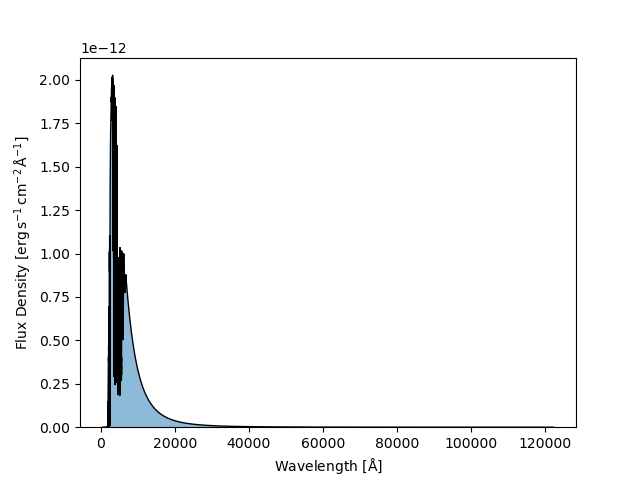

In [38]:
MySource = PointSource()

temp = 6500
abundance = 4.5
spectral_type = "DQ"

w, flux = read_spectra(spectral_type, temp, abundance)
    
MySource.set_spectrum(wavelengths = w, spectrum = flux, unit = 'fnu')

MySource.norm_to_AB_mag(10)

MySource.show_spectrum()

## Step 4) Do spectroscopy


In [39]:
MySpec = UVMOS_Spectroscopy(MyTelescope, MySource, MyBackground)

In [40]:
MySpec.dipersion = 0.061 * u.nm

In [41]:
MySpec.specify_slit()

In [42]:
MySpec.calc_source_CASTORSpectrum(extraction_width=1, extraction_lowerlim=4, extraction_upperlim = 7)
MySpec.calc_background_CASTORSpectrum(extraction_width=1, extraction_lowerlim=4, extraction_upperlim = 7)

(<Quantity 2.80920937 Angstrom>, <Quantity 4.41480485 Angstrom>)


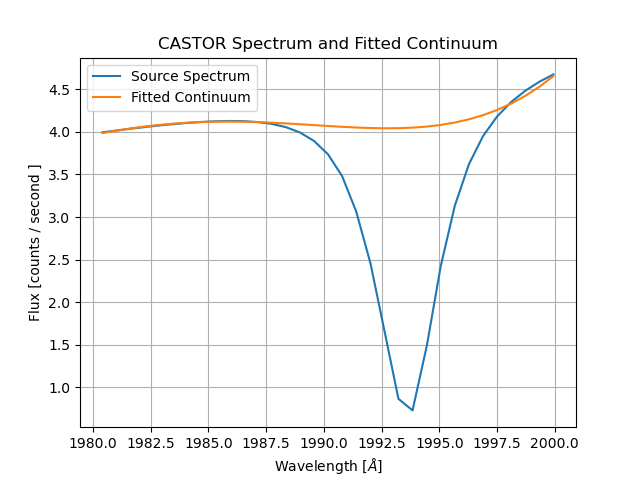

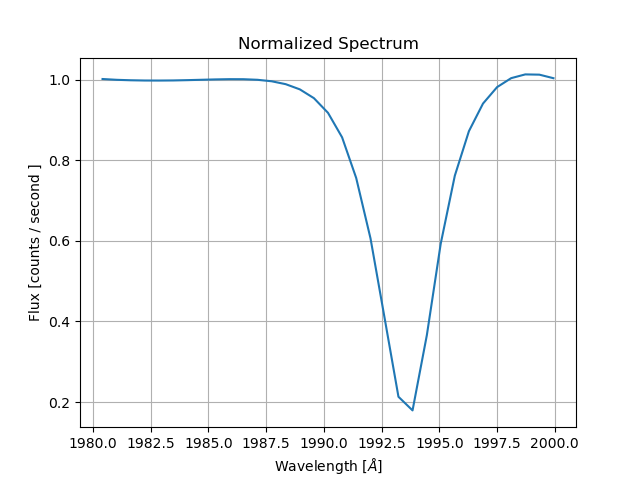

In [43]:
print(EquivalentWidth(region=[1987.52, 1997.49], t=1000, wave=1993.81))

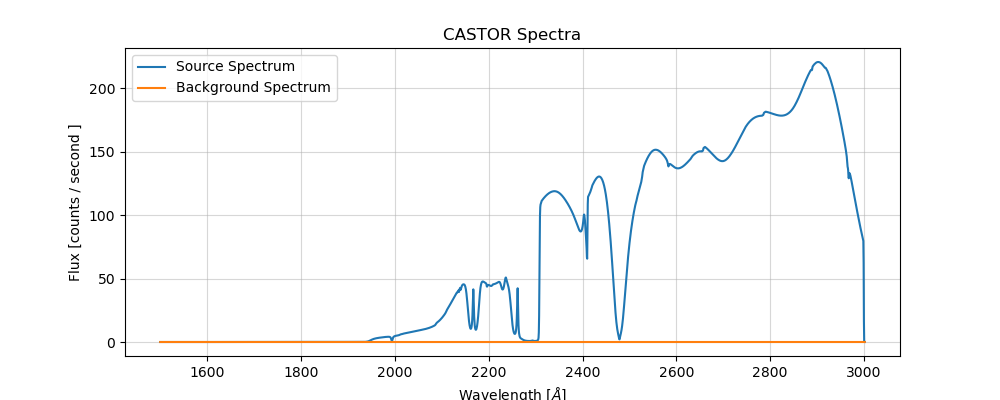

In [44]:
%matplotlib widget

plt.figure(figsize=(10,4))
ax = plt.subplot(111)
plt.plot(MySpec.waves_CASTORSpectrum, MySpec.source_CASTORSpectrum,'-',label='Source Spectrum')

plt.plot(MySpec.waves_CASTORSpectrum, MySpec.background_CASTORSpectrum*MySpec.source_extracted_numpixs,'-',label='Background Spectrum')

plt.title('CASTOR Spectra')
plt.xlabel('Wavelength '+r'[$\AA$]')
plt.ylabel('Flux [counts / second ]')
plt.grid(alpha=0.5)
plt.legend()
plt.show()

**Determine exposure times or signal-to-noise ratios**

In [48]:
t = 1000 # seconds
wave = 1993.81 # angstroms
snr = MySpec.calc_snr_from_t(t, wave)
print('After an exposure time of {:.3f} seconds a SNR of {:.3f} is reached at a wavelength of {} angstroms'.format(t,snr, wave))

After an exposure time of 1000.000 seconds a SNR of 3.500 is reached at a wavelength of 1993.81 angstroms


In [49]:
snr = 30  
wave = 1993.81 # angstroms
t = MySpec.calc_t_from_snr(snr, wave)
print('An exposure time of {:.3g} seconds is required to reach a SNR of {:.3f} at a wavelength of {} angstroms'.format(t,snr, wave))

An exposure time of 9.91e+03 seconds is required to reach a SNR of 30.000 at a wavelength of 1993.81 angstroms


In [51]:
t = 1000
wave = 1993.81
print("SNR for a given region:", (calc_snr_for_region_from_t(t, wave, region=[1987.52, 1997.49])))

SNR for a given region: 3.5000125909649586
